In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import fsolve
from scipy.linalg import cho_solve, cho_factor

## 1. Define S(Q,t) function

In [2]:
def f_sqt_chain(Q, t, N=100, b=1.0, D=1.0, tau_R=1.0, p_max=10):
    """
    Compute the scattering function S(Q, t) for a Gaussian polymer chain.

    Parameters:
        Q (numpy.ndarray): Scattering vector magnitude (2D array)
        t (numpy.ndarray): Time (2D array)
        N (int): Number of beads in the polymer chain (default 100)
        b (float): Bond length (default 1.0)
        D (float): Diffusion coefficient (default 1.0)
        tau_R (float): Relaxation time (default 1.0)
        p_max (int): Number of terms in the summation for Phi_nm^1 (default 50)

    Returns:
        numpy.ndarray: Value of S(Q, t) (2D array)
    """

    # Indices for polymer beads
    n_values, m_values = np.meshgrid(np.arange(N), np.arange(N))
    abs_nm = np.abs(n_values - m_values)

    # Compute Phi_nm(t) components
    Phi_D = 6 * D * t  # Center-of-mass diffusion
    Phi_nm_0 = abs_nm * b**2  # Gaussian chain contribution

    # Compute Phi_nm^1 (dynamic part)
    Phi_nm_1 = ((4 * N * b**2 / np.pi**2) * 
                np.sum([(1 / p**2) * np.einsum('kl,ij->ijkl', 
                                               np.cos(p * np.pi * n_values / N) * np.cos(p * np.pi * m_values / N), 
                                               (1 - np.exp(-t * p**2 / tau_R))) 
                        for p in range(1, p_max+1)], # sum over p
                       axis=0))
    
    # Total Phi_nm
    Phi_nm = Phi_D[:, :, None, None] + Phi_nm_0[None, None, :, :] + Phi_nm_1
    
    # Compute S(Q, t) using einsum
    Q_squared = Q**2  # Shape [i, j]
    Q_squared_expanded = Q_squared[:, :, None, None]  # Shape [i, j, 1, 1]
    sqt = (1 / N) * np.einsum('ijkl,ijkl->ij', np.exp(- (1/6) * Q_squared_expanded * Phi_nm), np.ones_like(Phi_nm))


    return sqt


### Calculate S(Q, t) for a range of Q and t values

In [3]:
n_Q = 20
n_t = 30

t = (np.arange(n_t))/n_t*12
b = 0.5
N = 20
D = 0.1
Rg = np.sqrt(N*b**2/6)

QRg = (np.arange(n_Q))/n_Q*6
Q = QRg/Rg

Q_grid, t_grid = np.meshgrid(QRg, t)

sqt = f_sqt_chain(Q_grid, t_grid, N=N, b=b, D=D, tau_R=1.0, p_max=100)/n_Q

def f_sqt_sample(Q, t, N_count=1000, N=100, b=1.0, D=1.0, tau_R=1.0, p_max=10, seed=None, bg = 0.01):
    """
    Compute the scattering function S(Q, t) for a Gaussian polymer chain.

    Parameters:
        Q (numpy.ndarray): Scattering vector magnitude (2D array)
        t (numpy.ndarray): Time (2D array)
        N_count (int): Number of counts for each Q (default 1000)
        N (int): Number of beads in the polymer chain (default 100)
        b (float): Bond length (default 1.0)
        D (float): Diffusion coefficient (default 1.0)
        tau_R (float): Relaxation time (default 1.0)
        p_max (int): Number of terms in the summation for Phi_nm_1 (default 50)
    Returns:
        numpy.ndarray: Value of S(Q, t) (2D array)
    """
    
    np.random.seed(seed)
    sqt = f_sqt_chain(Q_grid, t_grid, N=N, b=b, D=D, tau_R=1.0, p_max=100)/n_Q
    Delta_sqt_sample = np.zeros((n_t, n_Q))
    sqt_sample = np.zeros((n_t, n_Q))
    for i in range(QRg.shape[0]):
        fit = (sqt)[:,i]+bg
        pit = fit/np.sum(fit)
        Nit = N_count*pit
        Delta_fit = np.sqrt(Nit)/N_count*np.sum(fit)
        Delta_sqt_sample[:,i] = Delta_fit
        
        bin_edges = np.linspace(0, len(t), len(t)+1)
        indices = np.random.choice(len(t), size=int(N_count), p=pit)
        N_sample_i, _ = np.histogram(indices, bins=bin_edges)
        sqt_sample_i = N_sample_i/N_count*np.sum(fit)
        sqt_sample[:,i] = sqt_sample_i
        
    return sqt_sample, Delta_sqt_sample, sqt

### Assign errorbar

In [12]:
bg = 0.0001
N_count = 1000
sqt_sample, Delta_sqt_sample, sqt = f_sqt_sample(Q_grid, t_grid, N_count=N_count, N=N, b=b, D=D, tau_R=1.0, p_max=100, seed=None, bg = bg)

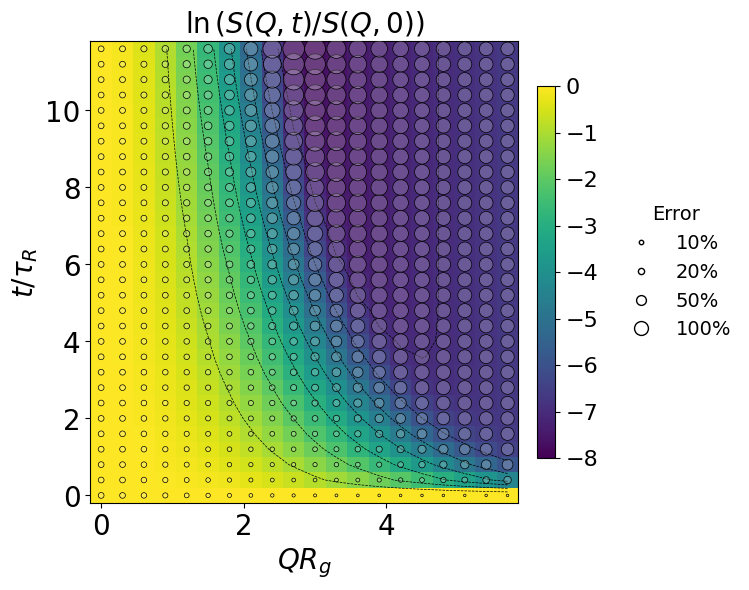

In [13]:
# Error wrt Q and t 
sq0 = sqt[0,:]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
scatter = ax.scatter(Q_grid, t_grid, s=Delta_sqt_sample*100/(sqt+bg), edgecolors='k', linewidths=0.5, facecolors=[1,1,1,0.2], zorder=10)

# Create a legend for the scatter plot sizes with specific error values (%)
error_values = [10, 20, 50, 100]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=np.sqrt(ev), fillstyle='none', markeredgecolor='k') for ev in error_values]
labels = [f'{ev}%' for ev in error_values]
legend2 = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.2, 0.5), title="Error", title_fontsize=14, frameon=False, fontsize=14)

# c = ax.contourf(Q_grid, t_grid, np.log(sqt/sq0), levels=np.linspace(-9, 0, 10), cmap='viridis', vmax=0, vmin=-8, zorder=-2)
c = ax.pcolormesh(Q_grid, t_grid, np.log((sqt+bg)/(sq0+bg)), cmap='viridis', vmax=0, vmin=-8, zorder=-2)
ax.contour(Q_grid, t_grid, np.log((sqt+bg)/(sq0+bg)), levels=np.linspace(-9, 0, 10), zorder=-1, colors='k', linewidths=0.5)
ax.set_title(r'$\ln{(S(Q,t)/S(Q,0))}$', fontsize=20)
fig.colorbar(c, ax=ax, fraction=0.04, pad=0.04).ax.tick_params(labelsize=16)
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.set_xlim([np.min(QRg), np.max(QRg)])
# ax.set_ylim([np.min(t), np.max(t)])
ax.tick_params(axis='both', which='major', labelsize=20)

## 2. Bayesian inference

In [14]:
def rbf_kernel(Q, lambda_):
    """Compute the spatial correlation kernel k_{i j}."""
    Q_i, Q_j = np.meshgrid(Q, Q, indexing='ij')
    return np.exp(-((Q_i - Q_j) ** 2) / (2 * lambda_ ** 2))

def construct_transformation_tensor(Q, t, tau):
    """Compute the transformation tensor C_{i m n}."""
    C = np.exp(-t[:, None] / tau[None, :])  # Shape (M, N)
    return np.tile(C[None, :, :], (len(Q), 1, 1))  # Expand to (L, M, N)

def bayesian_inference(S_exp, Q, t, tau, delta_S_exp, lambda_):
    """Perform Bayesian inference to estimate A_{i n} and its covariance using einsum."""
    # L: i, j
    # M: m, p
    # N: n, q
    L, M = S_exp.shape  # L: spatial points, M: time points
    N = len(tau)  # Expansion parameter size

    # Construct transformation tensor C_{i m n}
    C = construct_transformation_tensor(Q, t, tau)  # Shape (L, M, N)

    # Construct spatial covariance K_{i j}
    K = rbf_kernel(Q, lambda_)  # Shape (L, L)

    # Construct noise covariance Sigma_{i m, j m}
    Sigma = np.einsum('im,ij,mp->imjp', delta_S_exp**2, np.eye(L), np.eye(M))  # Shape (L, M, L, M)

    # Expand K to K_{i n, j q} using Kronecker product property
    K_expanded = np.einsum('ij,nq->injq', K, np.eye(N))  # Shape (L, N, L, N)

    # Construct modified covariance tensor \tilde{\Sigma}_{i, m, j, p}
    Sigma_tilde = Sigma + np.einsum('imn,injq,jpq->imjp', C, K_expanded, C)  # Shape (L, M, L, M)

    # Reshape for inversion
    Sigma_tilde_reshaped = Sigma_tilde.reshape(L*M, L*M)
    Sigma_tilde_inv = cho_solve(cho_factor(Sigma_tilde_reshaped), np.eye(L*M))
    Sigma_tilde_inv = Sigma_tilde_inv.reshape(L, M, L, M)  # Restore shape

    
    K_expanded_C = np.einsum('injq, jmq->imn', K_expanded, C)  # Shape (L, M, N)
    
    # Solve for posterior mean A_GPR_{i n}
    A_GPR = np.einsum('imn,imjp,jp->in', K_expanded_C, Sigma_tilde_inv, S_exp)  # Shape (L, N)

    # Compute posterior covariance K_GPR_{i, n, j, q}
    K_GPR = K_expanded - np.einsum('imn, imjp, jpq->injq', K_expanded_C, Sigma_tilde_inv, K_expanded_C)
    
    return A_GPR, K_GPR

/tmp/ipykernel_234064/3464582945.py:57: RuntimeWarning: invalid value encountered in log
  c = ax.pcolormesh(Q_grid, t_grid, np.log((sqt_GPR+bg)/(sq0_GPR+bg)).T, cmap='viridis', vmax=0, vmin=-8, zorder=-2)
/tmp/ipykernel_234064/3464582945.py:58: RuntimeWarning: invalid value encountered in log
  ax.contour(Q_grid, t_grid, np.log((sqt_GPR+bg)/(sq0_GPR+bg)).T, levels=np.linspace(-9, 0, 10), zorder=-1, colors='k', linewidths=0.5)


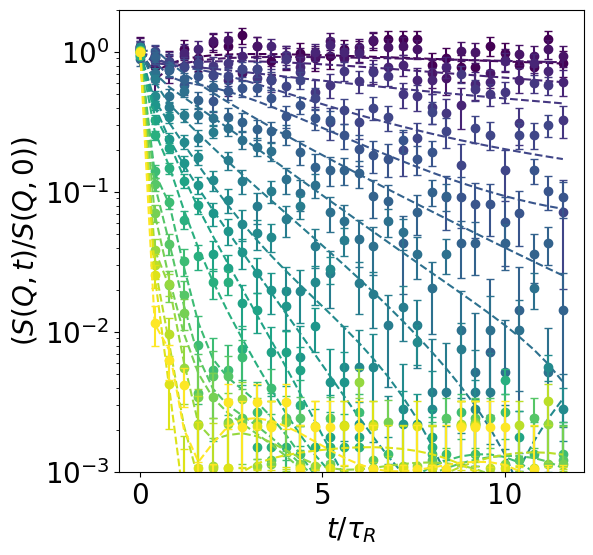

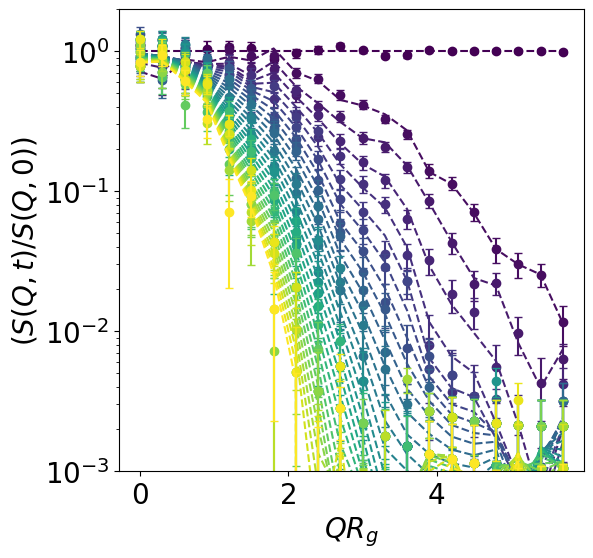

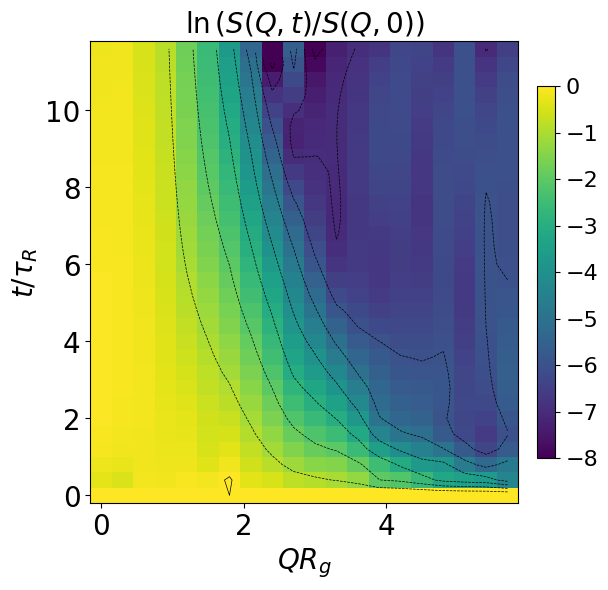

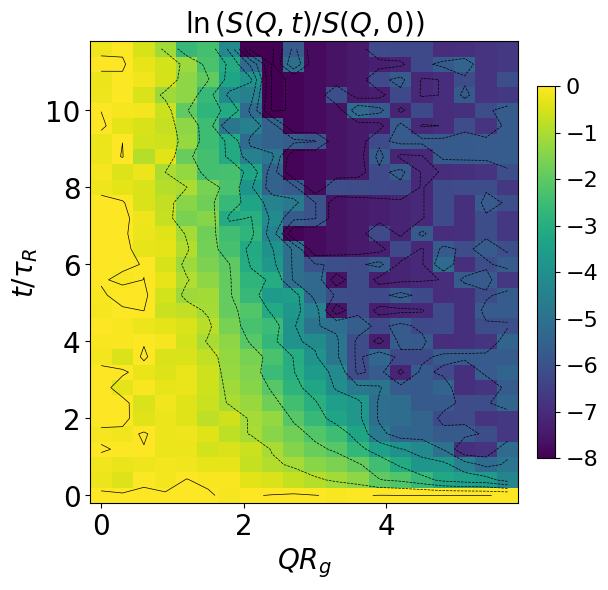

In [15]:
sqt_exp = sqt_sample.T
sq0_exp = sq0.T
delta_sqt_exp = Delta_sqt_sample.T
lambda_ = 0.05

N_Prony = 11
list_tau_i = np.exp(np.linspace(-5,5,N_Prony))
tau = np.array(list_tau_i)

A_GPR, K_GPR = bayesian_inference(sqt_exp, Q, t, tau, delta_sqt_exp, lambda_)

C = construct_transformation_tensor(Q, t, tau)  # Shape (L, M, N)
sqt_GPR = np.einsum('ik,ijk->ij', A_GPR, C)
C_0 = construct_transformation_tensor(Q, np.array([0]), tau)  # Shape (L, N)
sq0_GPR = np.einsum('ik,ijk->ij', A_GPR, C_0)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

colors = plt.cm.viridis(np.linspace(0, 1, len(Q)))

for i_q, q_plot in enumerate(Q):
    ax.plot(t, (sqt_exp[i_q, :])/sq0[i_q], 'o', color=colors[i_q])
    ax.errorbar(t, (sqt_exp[i_q, :])/sq0[i_q], yerr=delta_sqt_exp[i_q, :]/sq0[i_q], fmt='none', ecolor=colors[i_q], capsize=3)
    ax.plot(t, sqt_GPR[i_q, :]/sq0_GPR[i_q, :], '--', color=colors[i_q])
    
ax.set_xlabel(r'$t/\tau_R$', fontsize=20)
ax.set_ylabel(r'$(S(Q,t)/S(Q,0))$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
# ax.set_ylim([-0.1, 1.1])
ax.set_yscale('log')
ax.set_ylim([1e-3, 2])
# ax.set_xscale('log')

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

colors = plt.cm.viridis(np.linspace(0, 1, len(t)))

for i_t, t_plot in enumerate(t):
    ax.plot(QRg, (sqt_exp[:, i_t])/sq0[:], 'o', color=colors[i_t])
    ax.errorbar(QRg, (sqt_exp[:, i_t])/sq0[:], yerr=delta_sqt_exp[:, i_t]/sq0[:], fmt='none', ecolor=colors[i_t], capsize=3)
    ax.plot(QRg, (sqt_GPR/sq0_GPR)[:, i_t], '--', color=colors[i_t])
    
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$(S(Q,t)/S(Q,0))$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
# ax.set_ylim([-0.1, 1.1])
ax.set_yscale('log')
ax.set_ylim([1e-3, 2])
# ax.set_xscale('log')

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

# c = ax.contourf(Q_grid, t_grid, np.log(sqt/sq0), levels=np.linspace(-9, 0, 10), cmap='viridis', vmax=0, vmin=-8, zorder=-2)
c = ax.pcolormesh(Q_grid, t_grid, np.log((sqt_GPR+bg)/(sq0_GPR+bg)).T, cmap='viridis', vmax=0, vmin=-8, zorder=-2)
ax.contour(Q_grid, t_grid, np.log((sqt_GPR+bg)/(sq0_GPR+bg)).T, levels=np.linspace(-9, 0, 10), zorder=-1, colors='k', linewidths=0.5)
ax.set_title(r'$\ln{(S(Q,t)/S(Q,0))}$', fontsize=20)
fig.colorbar(c, ax=ax, fraction=0.04, pad=0.04).ax.tick_params(labelsize=16)
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.set_xlim([np.min(QRg), np.max(QRg)])
# ax.set_ylim([np.min(t), np.max(t)])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_facecolor(plt.cm.viridis(0))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

# c = ax.contourf(Q_grid, t_grid, np.log(sqt/sq0), levels=np.linspace(-9, 0, 10), cmap='viridis', vmax=0, vmin=-8, zorder=-2)
c = ax.pcolormesh(Q_grid, t_grid, np.log((sqt_exp+bg).T/(sq0_exp+bg).T), cmap='viridis', vmax=0, vmin=-8, zorder=-2)
ax.contour(Q_grid, t_grid, np.log((sqt_exp+bg).T/(sq0_exp+bg).T), levels=np.linspace(-9, 0, 10), zorder=-1, colors='k', linewidths=0.5)
ax.set_title(r'$\ln{(S(Q,t)/S(Q,0))}$', fontsize=20)
fig.colorbar(c, ax=ax, fraction=0.04, pad=0.04).ax.tick_params(labelsize=16)
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.set_xlim([np.min(QRg), np.max(QRg)])
# ax.set_ylim([np.min(t), np.max(t)])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_facecolor(plt.cm.viridis(0))
